In [9]:
# Imports, as always...
from pathlib import Path
import time
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam

from sklearn.model_selection import train_test_split as tts
from torch.utils.data import DataLoader
from scripts.data import QuantumDataset

import warnings
warnings.filterwarnings('ignore')

seed = 42
torch.random.manual_seed(seed)

test_split, val_split = .2, .2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

In [3]:
# Raw data.
raw_data = pd.concat([
    pd.read_csv(data_csv) 
    for data_csv in Path('./data/depth-varied').glob('*.csv')
], ignore_index=True)

# Subset for between devices of the same type:
subset_same = raw_data[raw_data['device'] != 'Aria-1'].replace({'Ankaa-3':0, 'Garnet':1})
# Subset for between devices of differing type:
subset_diff = raw_data[raw_data['device'] != 'Garnet'].replace({'Ankaa-3':0, 'Aria-1':1})

In [8]:
in_features = {'raw' : 32, 'res' : 32, 'abs_res' : 32, 'rel_res' : 32, 'abs_rel_res' : 32, 'log_ratio' : 32, 'qubit_res' : 5, 'abs_qubit_res' : 5, 'pauli_z_res' : 5, 'pauli_zz_res' : 10
}

In [4]:
# Helper function to create a balanced subset for two devices.
def stratified_sample(df, n, device_a_label=0, device_b_label=1, random_state=None):
    # Split into device 0 and device 1.
    df_0 = df[df['device'] == device_a_label]
    df_1 = df[df['device'] == device_b_label]
    
    # Too large an n?
    assert n <= len(df_0) and n <= len(df_1), 'n must be smaller than each dataset.'

    # Sample.
    sample_0 = df_0.sample(n=n, random_state=random_state)
    sample_1 = df_1.sample(n=n, random_state=random_state)
    
    # Combine and shuffle the result
    result = pd.concat([sample_0, sample_1]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return result

In [5]:
def binary_accuracy(logits, targets):
    # Case 1: BCE-style output
    if logits.ndim == 1 or logits.shape[1] == 1:
        logits = logits.view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
    # Case 2: CE-style output
    else:
        preds = torch.argmax(logits, dim=1)

    return (preds == targets).float().mean().item()

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    loss_fn_bce = nn.BCEWithLogitsLoss()
    loss_fn_ce = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)

            # Auto select loss
            if outputs.ndim == 1 or outputs.shape[1] == 1:
                outputs = outputs.view(-1)
                loss = loss_fn_bce(outputs, y.float())
            else:
                loss = loss_fn_ce(outputs, y)

            batch_size = y.size(0)
            acc = binary_accuracy(outputs, y)

            total_loss += loss.item() * batch_size
            total_acc += acc * batch_size
            total_samples += batch_size

    return total_loss / total_samples, total_acc / total_samples


In [15]:
%matplotlib inline
import copy

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    epochs,
    verbose=False,
    seed=42,
    early_stopping=True,
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True
):
    torch.random.manual_seed(seed)

    model.to(device)

    bce_loss = nn.BCEWithLogitsLoss()
    ce_loss  = nn.CrossEntropyLoss()

    # Metrics history
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    start_time = time.time()

    # ----- Early stopping state -----
    best_val_loss = float("inf")
    best_model_state = None
    epochs_without_improve = 0

    if verbose:
        # Interactive mode
        plt.ion()
        
        fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 5))

    for epoch in range(epochs):
        # ----- TRAIN -----
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        n = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)

            # Auto-detect output type
            if outputs.ndim == 1 or outputs.shape[1] == 1:
                outputs = outputs.view(-1)
                loss = bce_loss(outputs, y.float())
            else:
                loss = ce_loss(outputs, y)

            loss.backward()
            optimizer.step()

            bs = y.size(0)

            running_loss += loss.item() * bs
            running_acc += binary_accuracy(outputs, y) * bs
            n += bs

        train_loss = running_loss / n
        train_acc = running_acc / n

        # ----- VALIDATION -----
        val_loss, val_acc = evaluate(model, val_loader)

        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # ----- Early Stopping Logic -----
        if early_stopping:
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_without_improve = 0
            else:
                epochs_without_improve += 1

            if epochs_without_improve >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                if restore_best_weights and best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break

        if not verbose:
            continue

        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            # ----- ETA -----
            elapsed = time.time() - start_time
            done = epoch + 1
            time_per_epoch = elapsed / done
            remaining = time_per_epoch * (epochs - done)
            mins, secs = divmod(int(remaining), 60)

            # ----- Clear notebook output (text + figure) -----
            clear_output(wait=True)

            # ---- Update figure safely ----
            ax_loss.cla()
            ax_acc.cla()

            ax_loss.plot(train_losses, label="Train Loss")
            ax_loss.plot(val_losses, label="Val Loss")
            ax_loss.set_title("Loss")
            ax_loss.set_xlabel("Epoch")
            ax_loss.legend()
            ax_loss.set_xlim(0, epochs)

            ax_acc.plot(train_accs, label="Train Acc")
            ax_acc.plot(val_accs, label="Val Acc")
            ax_acc.set_title("Accuracy")
            ax_acc.set_xlabel("Epoch")
            ax_acc.legend(loc='lower right')
            ax_acc.set_ylim(.45, 1.01)
            ax_acc.set_xlim(0, epochs)

            fig.suptitle(f"Epoch {done}/{epochs} | ETA {mins:02d}:{secs:02d}")
            
            fig.canvas.draw()
            fig.canvas.flush_events()

            print(
                f"Epoch {done}/{epochs} | "
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
            )

    plt.ioff()

    # Restore best model at end if requested
    if early_stopping and restore_best_weights and best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, train_accs, val_losses, val_accs


ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

## Same-type Classification

Epoch 20/100 | Train Loss: 0.4557 | Train Acc: 0.7949 | Val Loss: 0.4842 | Val Acc: 0.7703


KeyboardInterrupt: 

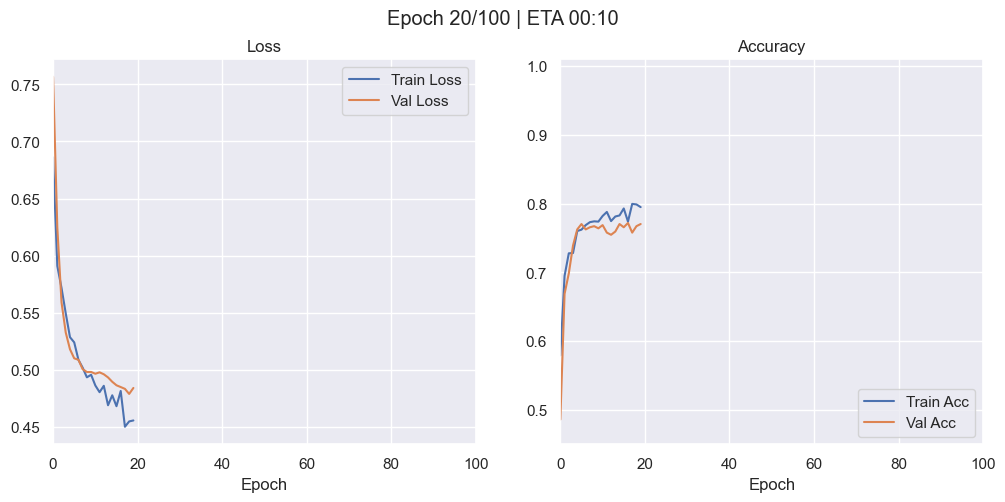

In [16]:
# Datasets.
feature_type = 'raw'
dataset = QuantumDataset(subset_same[subset_same['d'] < 25], feature_type)
train_set, test_set = tts(dataset, test_size=test_split, shuffle=True, random_state=seed)
train_set, val_set = tts(train_set, test_size=val_split, shuffle=True, random_state=seed)

# Dataloaders.
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Model.
model = nn.Sequential(
    nn.Linear(in_features[feature_type], 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(.5),
    nn.Linear(64, 16), nn.BatchNorm1d(16), nn.ReLU(), nn.Dropout(.5),
    nn.Linear(16, 2)
)
model.to(device)

# Train.
_ = train(
    model,
    train_loader,
    val_loader,
    Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    epochs=100,
    verbose=True
)

# Test.
evaluate(model, test_loader)